In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .appName("EDA for Silver Layer")\
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000")\
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

25/01/03 20:32:35 WARN Utils: Your hostname, hadoop resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/01/03 20:32:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/03 20:32:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/03 20:32:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
yfinance_silver_path = "/user/adam_majczyk2001/nifi/silver_parquet/yfinance/"
news_silver_path = "/user/adam_majczyk2001/nifi/silver_parquet/news/"

In [3]:
yfinance_df = spark.read.parquet(yfinance_silver_path)
news_df = spark.read.parquet(news_silver_path)

## 1. news_df

In [5]:
news_df.show(truncate=False)

+-------------------------------------------------------------------------------------------+--------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
news_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- is_premium: boolean (nullable = true)
 |-- source_site: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- random: string (nullable = true)



In [8]:
print(f"Number of rows in news_df: {news_df.count()}")

Number of rows in news_df: 974


In [9]:
# Check max and min datetime in news_df
news_df.agg({"datetime": "max"}).show()
news_df.agg({"datetime": "min"}).show()

+--------------------+
|       max(datetime)|
+--------------------+
|2025-01-03T00:00:...|
+--------------------+



+--------------------+
|       min(datetime)|
+--------------------+
|2020-11-18T00:00:...|
+--------------------+



In [ ]:
from pyspark.sql.functions import col, count

news_nulls = news_df.select([
    (count(col(c)) - news_df.count()).alias(c) for c in news_df.columns
])

news_nulls.show()

+-----+--------+--------+----------+-----------+---+----+------+
|title|datetime|keywords|is_premium|source_site|url|text|random|
+-----+--------+--------+----------+-----------+---+----+------+
|    0|       0|       0|         0|          0|  0|  -6|     0|
+-----+--------+--------+----------+-----------+---+----+------+



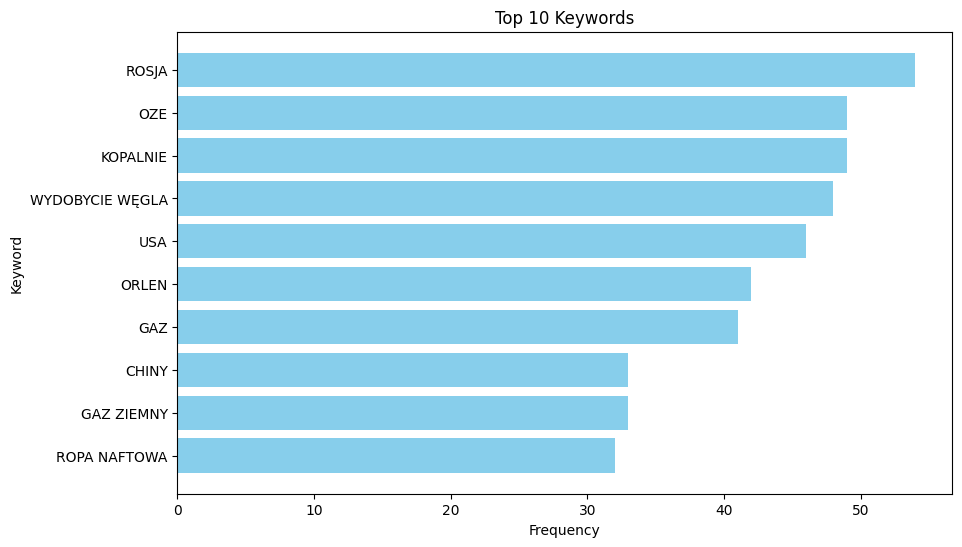

In [16]:
from pyspark.sql.functions import explode
import pandas as pd
import matplotlib.pyplot as plt

keywords_df = news_df.select(explode(col("keywords")).alias("keyword")).groupBy("keyword").count().orderBy(col("count").desc()).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(keywords_df['keyword'].head(10), keywords_df['count'].head(10), color='skyblue')
plt.title('Top 10 Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.gca().invert_yaxis()
plt.show()

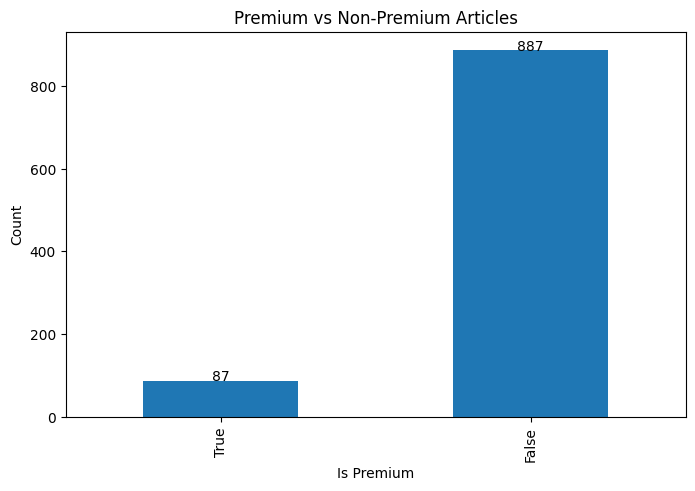

In [18]:
premium_counts = news_df.groupBy("is_premium").count().toPandas()
premium_counts.plot(kind='bar', x='is_premium', y='count', legend=False, figsize=(8, 5))
# Display count on top of each bar
for i in range(premium_counts.shape[0]):
    plt.text(i, premium_counts.iloc[i]['count'], premium_counts.iloc[i]['count'], ha = 'center')
plt.title('Premium vs Non-Premium Articles')
plt.xlabel('Is Premium')
plt.ylabel('Count')
plt.show()

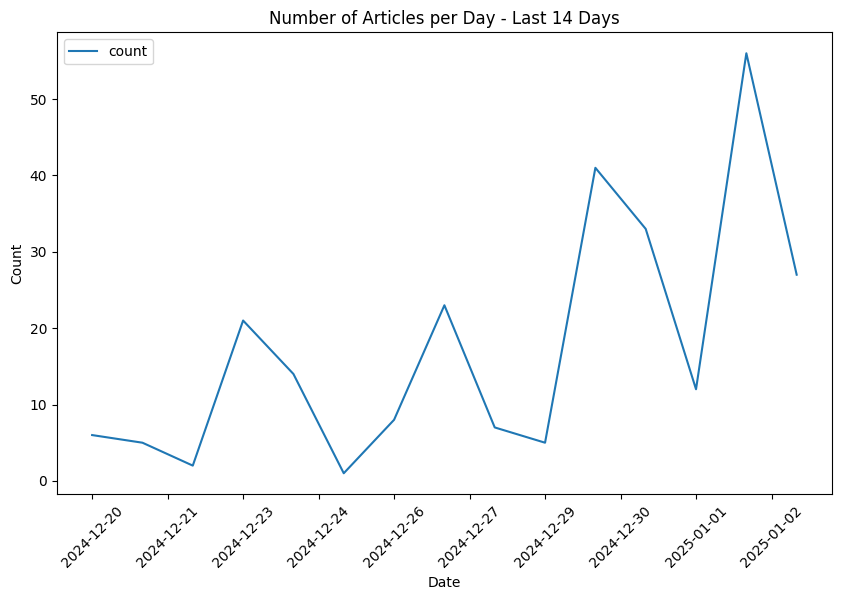

In [24]:
from pyspark.sql.functions import to_date, current_date, date_sub

# Number of articles per day
news_df.withColumn("datetime", to_date("datetime")).filter(news_df["datetime"] >= date_sub(current_date(), 14)).groupBy("datetime").count().orderBy("datetime").toPandas().plot(x="datetime", y="count", figsize=(10, 6))
plt.title('Number of Articles per Day - Last 14 Days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
# xticks each day
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

## 2. yfinance_df

In [4]:
yfinance_df.show(truncate=False)

+--------------------------+------+--------+----------+--------------+----------------+----------------+--------------------------+---------+-------+
|record_timestamp          |price |volume  |volatility|bid_ask_spread|market_sentiment|trading_activity|update_timestamp          |source   |company|
+--------------------------+------+--------+----------+--------------+----------------+----------------+--------------------------+---------+-------+
|2024-11-24T20:17:39.243508|65.58 |3884324 |0.578     |0.0341        |-0.752          |65.06           |2024-11-24T20:12:39.583619|simulated|SHEL   |
|2024-11-24T20:17:39.243508|29.67 |16368838|1.513     |0.0136        |-0.426          |46.16           |2024-11-24T20:12:42.501631|simulated|BP     |
|2024-11-24T20:17:39.243508|122.1 |6527058 |1.339     |0.0581        |-0.679          |82.58           |2024-11-24T20:12:43.978946|simulated|XOM    |
|2024-11-24T20:17:39.243508|29.67 |16554556|1.539     |0.0138        |-0.372          |46.55        

In [6]:
yfinance_df.printSchema()

root
 |-- record_timestamp: string (nullable = true)
 |-- price: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- volatility: double (nullable = true)
 |-- bid_ask_spread: double (nullable = true)
 |-- market_sentiment: double (nullable = true)
 |-- trading_activity: double (nullable = true)
 |-- update_timestamp: string (nullable = true)
 |-- source: string (nullable = true)
 |-- company: string (nullable = true)

